# 01 - CNN preprocessing comparison

__Andrés Felipe García Albarracín <br>
May 7, 2021__

In [1]:
import tensorflow as tf
import os
from shutil import copyfile
import pandas as pd
import time
import math

## 1. Order data in the training / validation folders

In [2]:
# Run the following the first time

trainingFolder = "../Datasets/flowers/training"
validationFolder = "../Datasets/flowers/validation"
firstTime = not(os.path.exists(trainingFolder) and os.path.exists(validationFolder))

def safeCreateFolder(folderPath):
    """
    Creates a folder if it does not exist
    """
    if not os.path.exists(folderPath):
        os.mkdir(folderPath)

if firstTime:
    # Unzip files
    from zipfile import ZipFile

    with ZipFile(os.path.join("../Datasets/archive.zip"), 'r') as zipObj:
        zipObj.extractall(os.path.join("../Datasets/flowers"))

    # Create folders
    safeCreateFolder(trainingFolder)
    safeCreateFolder(validationFolder)
    
    # Split function
    def splitFiles(sourcePath, trainingPath, validationPath, splitSize):
        """
        Function that splits the files from sourcePath in trainingPath and
        validationPath, according to the splitSize
        """
        folderList = os.listdir(sourcePath)
        for folder in folderList:
            safeCreateFolder(os.path.join(trainingPath,folder))
            safeCreateFolder(os.path.join(validationPath,folder))
            fileList = os.listdir(os.path.join(sourcePath, folder))
            for n, file in enumerate(fileList):
                if n < splitSize * len(fileList):
                    copyfile(
                        os.path.join(sourcePath, folder, file),
                        os.path.join(trainingPath, folder, file)
                    )
                else:
                    copyfile(
                        os.path.join(sourcePath, folder, file),
                        os.path.join(validationPath, folder, file)
                )
    
    # Call the functions
    splitRatio = 0.7
    splitFiles(
        sourcePath = "../Datasets/flowers/flowers",
        trainingPath = trainingFolder,
        validationPath = validationFolder,
        splitSize = splitRatio
    )

## 2. Define the model to use

In [3]:
def createAndCompile(numClases):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (pic_size, pic_size, 3)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(numClases, activation = 'softmax')
    ])
    #run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    model.compile(
        optimizer = tf.keras.optimizers.Adam(),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        metrics = ['accuracy']
    #    options = run_opts
    )
    return model


In [4]:
numClases = len(os.listdir(trainingFolder))

## 3. Strategies

In [5]:
batch_size = 8
pic_size = 150
dfResults = pd.DataFrame(columns=['Experiment', 'Training time', 'Evaluation time'])

### 3.1 Image Data Generator

In [6]:
trainDataGen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
train_generator = trainDataGen.flow_from_directory(
    trainingFolder,
    batch_size = batch_size,
    target_size = (pic_size,pic_size),
    class_mode = 'categorical',
    seed = 1
)
validationDataGen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
validation_generator = validationDataGen.flow_from_directory(
    validationFolder,
    batch_size = batch_size,
    target_size = (pic_size,pic_size),
    class_mode = 'categorical',
    seed = 1
)

Found 3028 images belonging to 5 classes.
Found 1295 images belonging to 5 classes.


In [7]:
model1 = createAndCompile(numClases)

In [8]:
start = time.time()
model1.fit(
    train_generator,
    epochs = 10,
    steps_per_epoch = math.ceil(train_generator.samples/batch_size)
)
trainTime = time.time() - start
start = time.time()
model1.evaluate(
    validation_generator,
    steps = math.ceil(validation_generator.samples/batch_size)
)
evalTime = time.time() - start

Epoch 1/10
379/379 [==============================] - 7s 20ms/step - loss: 1.4338 - accuracy: 0.3930
Epoch 2/10
379/379 [==============================] - 7s 19ms/step - loss: 1.1119 - accuracy: 0.5525
Epoch 3/10
379/379 [==============================] - 7s 20ms/step - loss: 0.9111 - accuracy: 0.6513
Epoch 4/10
379/379 [==============================] - 8s 20ms/step - loss: 0.6925 - accuracy: 0.7454
Epoch 5/10
379/379 [==============================] - 8s 21ms/step - loss: 0.4739 - accuracy: 0.8329
Epoch 6/10
379/379 [==============================] - 8s 21ms/step - loss: 0.3392 - accuracy: 0.8824
Epoch 7/10
379/379 [==============================] - 8s 21ms/step - loss: 0.2440 - accuracy: 0.9214
Epoch 8/10
379/379 [==============================] - 8s 21ms/step - loss: 0.1508 - accuracy: 0.9505
Epoch 9/10
379/379 [==============================] - 8s 21ms/step - loss: 0.1305 - accuracy: 0.9577
Epoch 10/10
162/162 [==============================] - 3s 20ms/step - loss: 1.7150 - accura

In [9]:
dfResults = dfResults.append({
    'Experiment': '1. ImageDataGenerator',
    'Training time': trainTime,
    'Evaluation time': evalTime},
    ignore_index=True)

### 3.2 Image Data Generator > tf.data with Prefetch

In [10]:
tuple([tf.float32]*3)

(tf.float32, tf.float32, tf.float32)

In [11]:
train_generator = trainDataGen.flow_from_directory(
        trainingFolder,
        batch_size = batch_size,
        target_size = (pic_size,pic_size),
        class_mode = 'categorical',
        seed = 1
        )

trainDataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types = tuple([tf.float32]*2),
    output_shapes = ([None, pic_size, pic_size, 3], [None, numClases])
)

validation_generator = validationDataGen.flow_from_directory(
        validationFolder,
        batch_size = batch_size,
        target_size = (pic_size,pic_size),
        class_mode = 'categorical',
        seed = 1
        )

validationDataset = tf.data.Dataset.from_generator(
    lambda: validation_generator,
    output_types = tuple([tf.float32]*2),
    output_shapes = ([None, pic_size, pic_size, 3], [None, numClases])
)

trainDataset = trainDataset.prefetch(1)
validationDataset = validationDataset.prefetch(1)

Found 3028 images belonging to 5 classes.
Found 1295 images belonging to 5 classes.


In [12]:
model2 = createAndCompile(numClases)

In [13]:
start = time.time()
model2.fit(
    trainDataset,
    epochs = 10,
    steps_per_epoch = math.ceil(train_generator.samples/batch_size)
)
trainTime = time.time() - start
start = time.time()
model2.evaluate(
    validationDataset,
    steps = math.ceil(validation_generator.samples/batch_size)
)
evalTime = time.time() - start

Epoch 1/10
379/379 [==============================] - 8s 20ms/step - loss: 1.4750 - accuracy: 0.3841
Epoch 2/10
379/379 [==============================] - 8s 21ms/step - loss: 1.1990 - accuracy: 0.5178
Epoch 3/10
379/379 [==============================] - 8s 21ms/step - loss: 0.9770 - accuracy: 0.6235
Epoch 4/10
379/379 [==============================] - 8s 20ms/step - loss: 0.7205 - accuracy: 0.7305
Epoch 5/10
379/379 [==============================] - 8s 20ms/step - loss: 0.5308 - accuracy: 0.8147
Epoch 6/10
379/379 [==============================] - 8s 21ms/step - loss: 0.3609 - accuracy: 0.8742
Epoch 7/10
379/379 [==============================] - 8s 21ms/step - loss: 0.2853 - accuracy: 0.9049
Epoch 8/10
379/379 [==============================] - 8s 21ms/step - loss: 0.2300 - accuracy: 0.9297
Epoch 9/10
379/379 [==============================] - 8s 21ms/step - loss: 0.1742 - accuracy: 0.9482
Epoch 10/10
162/162 [==============================] - 3s 22ms/step - loss: 2.0890 - accura

In [14]:
dfResults = dfResults.append({
    'Experiment': '2. ImageDataGenerator > tf.Data',
    'Training time': trainTime,
    'Evaluation time': evalTime},
    ignore_index=True)

### 3.3 tf.data with image_dataset_from_directory

In [15]:
trainDataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = trainingFolder,
    label_mode = 'categorical',
    batch_size = batch_size,
    image_size = (pic_size, pic_size),
    seed = 1
)

validationDataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = validationFolder,
    label_mode = 'categorical',
    batch_size = batch_size,
    image_size = (pic_size, pic_size),
    seed = 1
)

trainDataset = trainDataset.map(lambda x,y: (x/255, y)).prefetch(1)
validationDataset = validationDataset.map(lambda x,y: (x/255, y)).prefetch(1)

Found 3028 files belonging to 5 classes.
Found 1295 files belonging to 5 classes.


In [16]:
model3 = createAndCompile(numClases)

In [17]:
start = time.time()
model3.fit(
    trainDataset,
    epochs = 10
    #steps_per_epoch = math.ceil(train_generator.samples/batch_size)
)
trainTime = time.time() - start
start = time.time()
model3.evaluate(
    validationDataset
    #steps = math.ceil(validation_generator.samples/batch_size)
)
evalTime = time.time() - start

Epoch 1/10
379/379 [==============================] - 5s 14ms/step - loss: 1.4910 - accuracy: 0.3715
Epoch 2/10
379/379 [==============================] - 5s 14ms/step - loss: 1.1248 - accuracy: 0.5512
Epoch 3/10
379/379 [==============================] - 5s 14ms/step - loss: 0.9158 - accuracy: 0.6480
Epoch 4/10
379/379 [==============================] - 5s 13ms/step - loss: 0.6436 - accuracy: 0.7642
Epoch 5/10
379/379 [==============================] - 5s 13ms/step - loss: 0.4546 - accuracy: 0.8438
Epoch 6/10
379/379 [==============================] - 5s 13ms/step - loss: 0.3402 - accuracy: 0.8887
Epoch 7/10
379/379 [==============================] - 5s 13ms/step - loss: 0.2458 - accuracy: 0.9247
Epoch 8/10
379/379 [==============================] - 5s 13ms/step - loss: 0.2067 - accuracy: 0.9369
Epoch 9/10
379/379 [==============================] - 6s 15ms/step - loss: 0.1487 - accuracy: 0.9567
Epoch 10/10
162/162 [==============================] - 2s 13ms/step - loss: 1.9039 - accura

In [18]:
dfResults = dfResults.append({
    'Experiment': '3. tf.Data with image_dataset_from_directory',
    'Training time': trainTime,
    'Evaluation time': evalTime},
    ignore_index=True)

In [19]:
dfResults

,Experiment,Training time,Evaluation time
0,1. ImageDataGenerator,78.894065,3.537202
1,2. ImageDataGenerator > tf.Data,79.457165,3.657173
2,3. tf.Data with image_dataset_from_directory,54.406635,2.446303


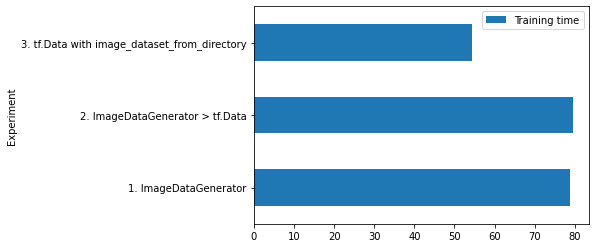

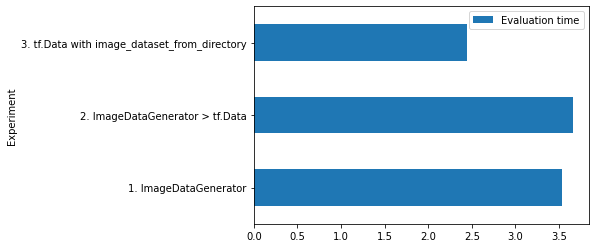

In [20]:
dfResults.plot.barh(x = 'Experiment', y = 'Training time')
dfResults.plot.barh(x = 'Experiment', y = 'Evaluation time')